In [ ]:
# # This file is part of Theano Geometry
#
# Copyright (C) 2017, Stefan Sommer (sommer@di.ku.dk)
# https://bitbucket.org/stefansommer/theanogemetry
#
# Theano Geometry is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# Theano Geometry is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with Theano Geometry. If not, see <http://www.gnu.org/licenses/>.
#

# $\mathbb{S}^2$ Sphere Geometry

In [1]:
from src.manifolds.S2 import *
M = S2()
print(M)

from src.plotting import *
#%matplotlib notebook

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


2d sphere (ellipsoid parameters [1. 1. 1.], spherical_coords: False)


In [2]:
# Riemannian structure
from src.Riemannian import metric
metric.initialize(M)

# element, tangent vector and covector
x = np.array([0.,0.])
v = np.array([1.,0.])
p = M.flatf(x,v)

print("x = ", x)
print("v = ", v)
print("p = ", p)

x =  [0. 0.]
v =  [1. 0.]
p =  [4. 0.]


## Riemannian Geodesics

In [ ]:
# 2nd order geodesic equation
from src.Riemannian import geodesic
geodesic.initialize(M)

# compute geodesics
xs = M.Exptf(x,v)

# plot
newfig()
M.plot()
M.plot()
M.plotx(xs,v,linewidth = 1.5, s=50)
plt.show()

### Geodesics from Hamiltonian equations

In [ ]:
# Hamiltonian dynamics
q = x
print(M.Hf(q,p))

from src.dynamics import Hamiltonian
Hamiltonian.initialize(M)

# Exponential map from Hamiltonian equations
qs = M.Exp_Hamiltoniantf(q,p).T

# plot
newfig()
M.plot()
M.plotx(qs,v)
plt.show()

# dynamics returning both position and momentum
(ts,qps) = M.Hamiltonian_dynamicsf(q,p)
ps = qps[:,1,:]
print("Energy: ",np.array([M.Hf(q,p) for (q,p) in zip(qs,ps)]))

## Curvature

In [ ]:
from src.Riemannian import curvature
curvature.initialize(M)
# Curvature tensor, Ricci and scalar curvature:
print("curvature = ", M.Rf(x))
print("Ricci curvature = ", M.Ricci_curvf(x))
print("Scalar curvature = ", M.S_curvf(x))

# Orthonormal basis under g:
nu = M.gramSchmidt(x,np.eye(2)) # or nu = np.linalg.cholesky(M.gsharpf(x))

# Sectional Curvature
print("sectional curvature = ",M.sec_curvf(x,nu[:,0],nu[:,1]))

## Parallel Transport

In [ ]:
# Parallel transport
from src.Riemannian import parallel_transport
parallel_transport.initialize(M)

v = np.array([-1./2,-1./2])
v = v/M.normf(x,v)
t = np.linspace(0,1,n_steps.get_value())
gamma = np.vstack([t**2,-np.sin(t)]).T
dgamma = np.vstack([2*t,-np.cos(t)]).T

# compute  parallel transport
vt = M.parallel_transportf(v,gamma,dgamma)

# plot result
newfig()
M.plot()
M.plotx(gamma,v=vt)
plt.show()

## Brownian Motion

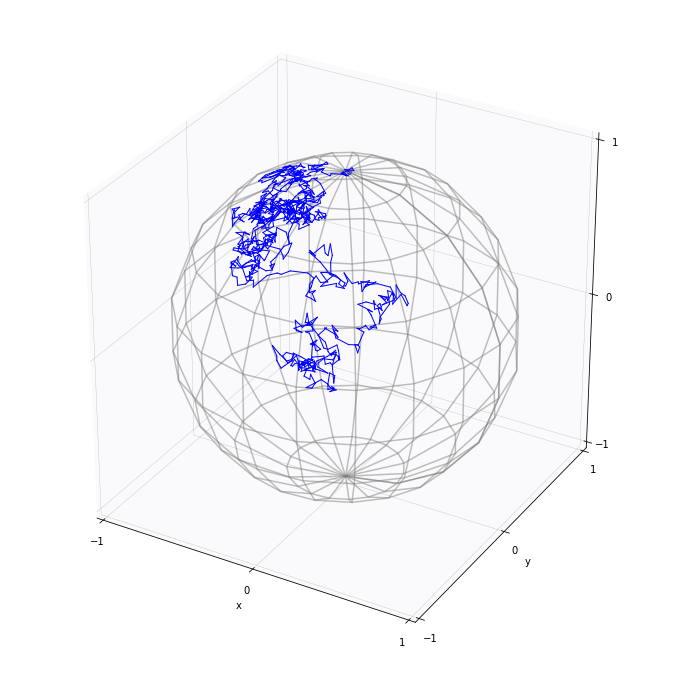

In [3]:
# coordinate form
from src.stochastics import Brownian_coords
Brownian_coords.initialize(M)

n_steps.set_value(1000)
(ts,xs) = M.Brownian_coordsf(x,dWsf(M.dim.eval()))

# plot
newfig()
M.plot()
M.plotx(xs)
plt.show()

In [ ]:
# Brownian Motion from stochastic development
from src.framebundle import FM
from src.stochastics import stochastic_development
from src.stochastics import Brownian_development

FM.initialize(M)
stochastic_development.initialize(M)
Brownian_development.initialize(M)

# simulate Brownian Motion
(ts,xsv) = M.Brownian_developmentf(x,dWsf(M.dim.eval()))

# plot
newfig()
M.plot()
M.plotx(xsv)
plt.show()

In [ ]:
x = M.element()
dW = M.element()
t = T.scalar()

def sde_Brownian_coords2(dW,t,x):
    gsharpx = M.gsharp(x)
    X = theano.tensor.slinalg.Cholesky()(gsharpx)
    det = -1./2*T.tensordot(gsharpx,M.Gamma_g(x),((0,1),(0,1)))
    sto = T.tensordot(X,dW,(1,0))
    return (det,sto,X)
M.sde_Brownian_coords2 = sde_Brownian_coords2
M.sde_Brownian_coordsf2 = theano.function([dW,t,x], M.sde_Brownian_coords2(dW,t,x), on_unused_input = 'ignore') 
M.Brownian_coords2 = lambda x,dWt: integrate_sde(sde_Brownian_coords2,integrator_,x,dWt)
M.Brownian_coordsf2 = theano.function([x,dWt], M.Brownian_coords2(x,dWt))

In [ ]:
#n_steps.set_value(1000)
#W = dWsf(M.dim.eval())
x0 = np.array([0.,0.])
(ts,xs) = M.Brownian_coordsf2(x0,W)#dWsf(M.dim.eval()))

# plot
newfig()
M.plot()
M.plotx(xs)
plt.show()

In [ ]:
# Delyon/Hu guided process
from src.stochastics.guided_process import *

# guide function
Cholesky = T.slinalg.Cholesky()
# phi = lambda q,v: T.tensordot(T.nlinalg.MatrixInverse()(Cholesky(M.gsharp(q))),-(q-v).flatten(),(1,0))
phi = lambda q,v: T.tensordot(Cholesky(M.gsharp(q)).T,-(q-v).flatten(),(1,0))
x0 = M.element()
(Brownian_coords_guided,Brownian_coords_guidedf) = get_guided_likelihood(M,M.sde_Brownian_coords,phi,lambda x: Cholesky(M.gsharp(x)),x0)

n_steps.set_value(1000)

w = M.Exptf(x,np.array([.8,-.5]))[-1]
(ts,xs,log_likelihood,log_varphi) = Brownian_coords_guidedf(x,w,dWsf(M.dim.eval()))[:4]
print("log likelihood: ", log_likelihood[-1], ", log varphi: ", log_varphi[-1])

# plot
newfig()
M.plot()
M.plotx(xs)
M.plotx(x,color='r',s=150)
M.plotx(w,color='k',s=150)
plt.show()